In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from superlets.superlets import wavelet_transform, adaptive_superlet_transform

We first generate a signal similar to that used in Fig. 3 of the paper. For this demo, we use three bursts 11 cycles long, with frequency 20Hz, 40Hz and 60Hz each. Each burst is "contaminated" by neighbors both in time and frequency. The neighbors in frequency are 10Hz higher than the original values overlapping with the original signal, while the neighbors in time begin 2 cycles later, and last for 12 cycles. The entire signal is generated with a sampling rate of 1024 samples per second.

In [3]:
fs = 1024
burst_freqs = [20, 40, 60]
f_shift = 10
n_cycles = 11
n_neighb_cycles = 12

ys = []

# create a 0.1s blank signal to start
ys.append(jnp.zeros(int(fs*0.1)))

for f in burst_freqs:
  # frequency contaminated signal
  t = 1/f * n_cycles
  x = jnp.linspace(0, t, int(t * fs))
  y = jnp.sin(2*jnp.pi*f*x) + jnp.sin(2*jnp.pi*(f+f_shift)*x - jnp.pi/1.5)
  ys.append(y)

  # time contaminated signal, 2 cycles later
  ys.append(jnp.zeros(int(fs*(1/f)*2)))
  
  t2 = 1/f * n_neighb_cycles
  x = jnp.linspace(0, t2, int(t2 * fs))
  y = jnp.sin(2*jnp.pi*f*x)
  ys.append(y)

  # space between bursts of 0.1s
  ys.append(jnp.zeros(int(fs*0.1)))

signal = jnp.concatenate(ys)

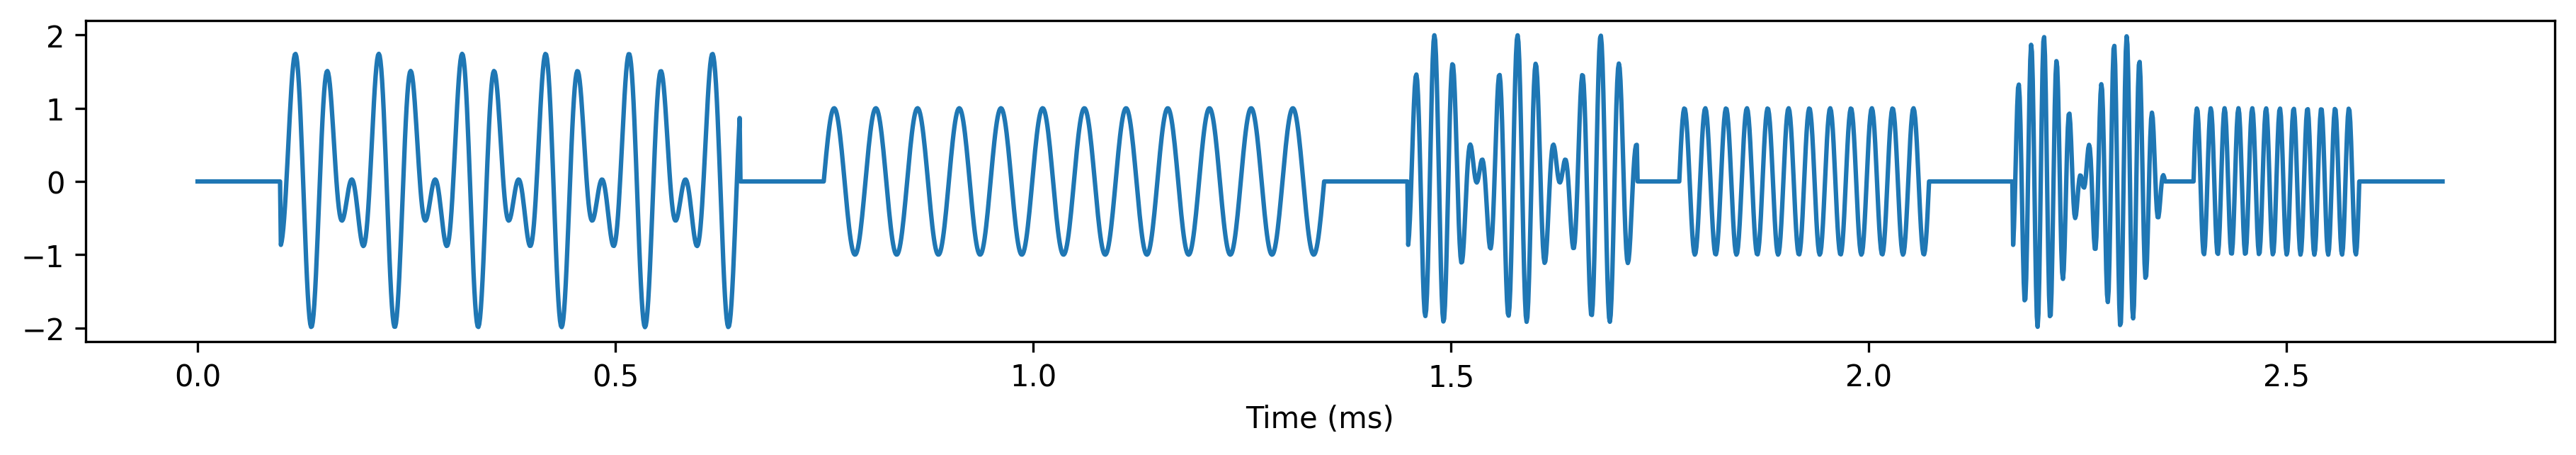

In [11]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)

We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [5]:
freqs = jnp.linspace(10, 80, 141)

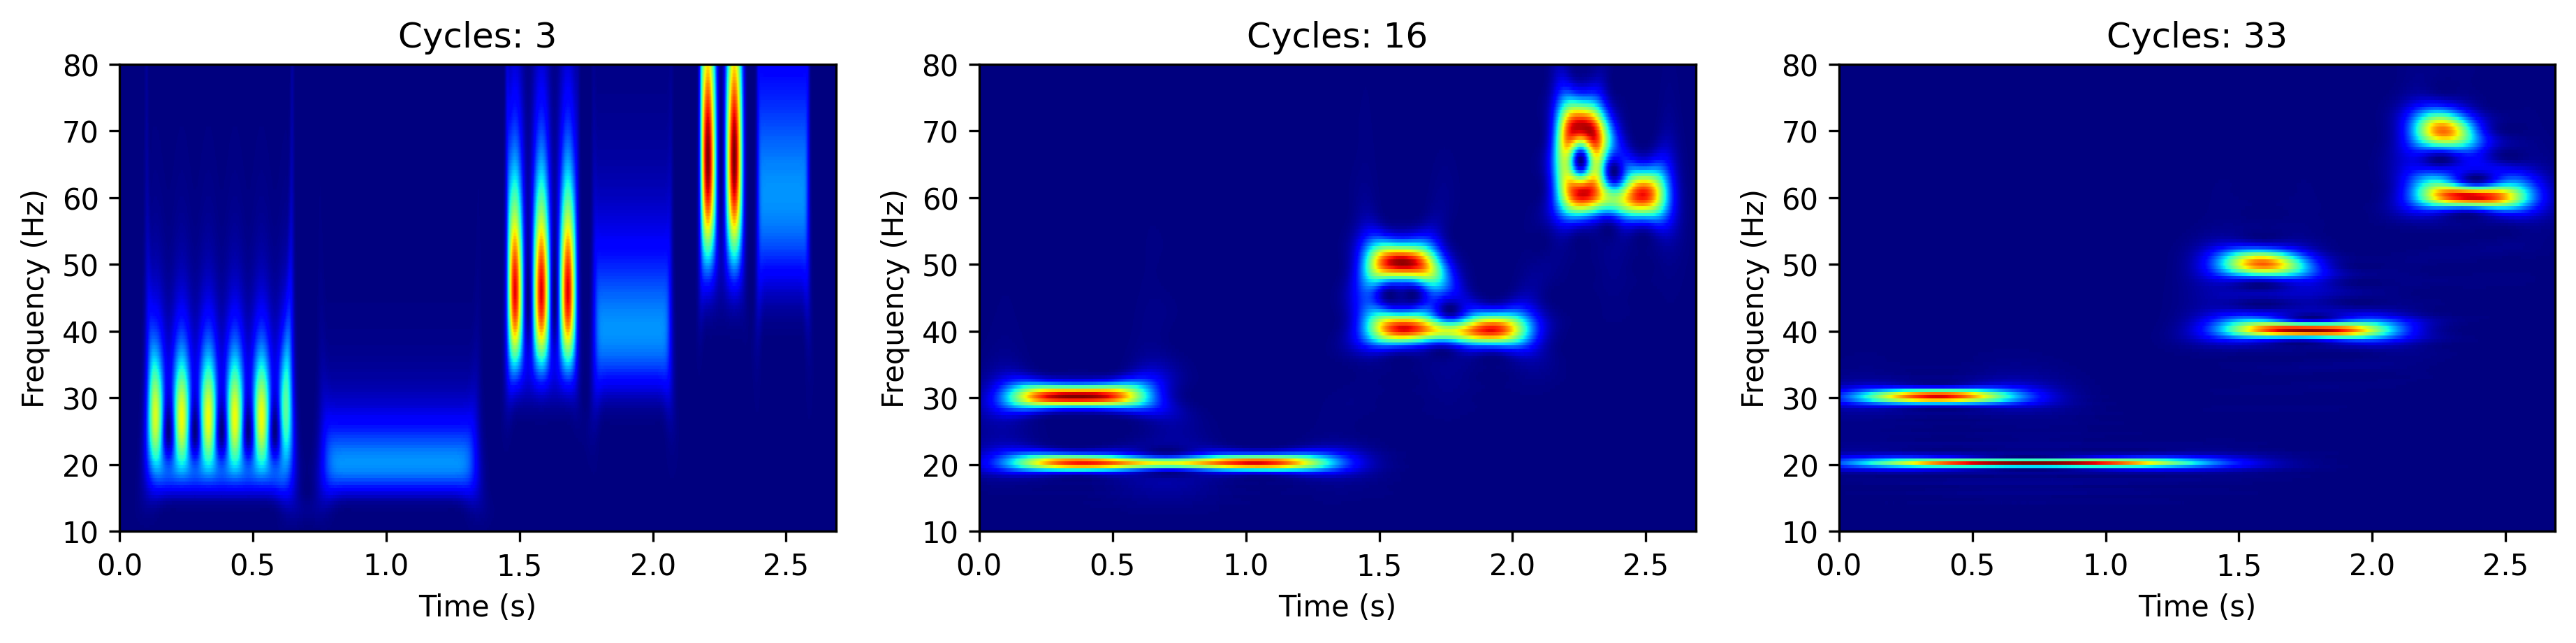

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for i, c in enumerate([3, 16, 33]):
    scalogram = wavelet_transform(signal, freqs, c, fs)
    ax[i].imshow(jnp.abs(scalogram)**2, aspect=1/40, cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Cycles: {c}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")

There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

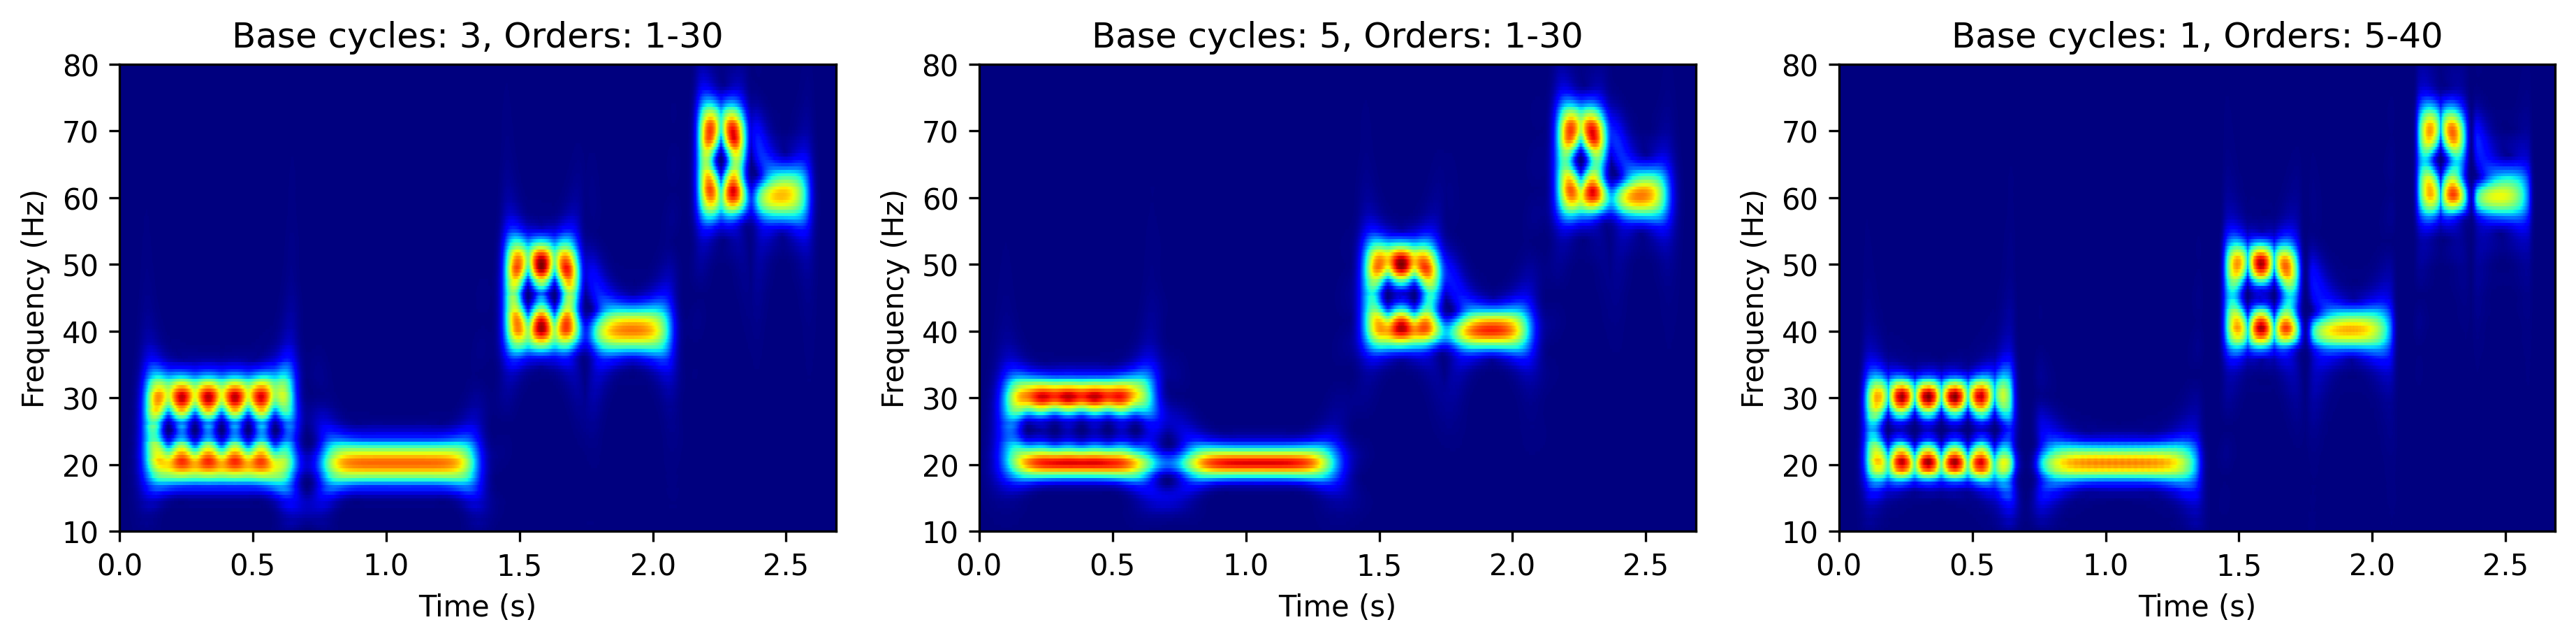

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), dpi=300)

for (i, (base_cycle, min_order, max_order)) in enumerate(zip([3, 5, 1], [1, 1, 5], [30, 30, 40])):
    scalogram = adaptive_superlet_transform(signal, freqs, sampling_freq=fs, 
                                        base_cycle=base_cycle, min_order=min_order, max_order=max_order, mode="add")
    ax[i].imshow(jnp.abs(scalogram)**2, aspect=1/40, cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]])
    ax[i].set_title(f"Base cycles: {base_cycle}, Orders: {min_order}-{max_order}")
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Frequency (Hz)")